In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from dark_emulator_public import dark_emulator
import os, sys
import matplotlib.pyplot as plt
import my_python_package as mpp
from collections import OrderedDict as od
from pyhalofit import pyhalofit
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp2d
from time import time
from scipy.integrate import simps
from tqdm import tqdm
import hsc3x2pt

using dark_emulator at  /Users/sunao-mac/Documents/python_package/dark_emulator_public/dark_emulator/__init__.py


## pyhalofitのaccuracy担保
notebook `highz_halofit` によって、highzではnaiveにlinear powerを突っ込んだだけでは正しいhalofitを返さないことがわかった。これはhigh-zではlinear growthが小さいので、$\sigma(R)=1$となるようなRが小さく、すなわちhigh kまでのlinear power spectrumの値を知っている必要があるからである。
なので、linear growth, $D_1(z)$が与えられたときに、どの程度high kまでのlinear powerを持っている必要があるか調べておけば、適宜linear powerを外挿or再計算することで対応できる。
$$
\begin{align}
    \sigma^2(R)
    &\equiv\int_0^\infty {\rm d}\ln k\Delta^2(k, z)e^{-k^2R^2}\\
    &= D_1^2(z) \int_0^\infty {\rm d}\ln k\Delta_0^2(k)e^{-k^2R^2}\\
    &= D_1^2(z)\sigma_0^2(R)
\end{align}
$$
ここで$\Delta_0^2(k)$はredshift依存性を外に出した形。

Dark emulatorは$k>10$では外挿している。ので外挿で行こう

In [3]:
power_b1 = hsc3x2pt.power_b1_class()

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [4]:
%%time
power_b1.init_pklin(10.0, kmax=1e3, kbin=1000)

CPU times: user 104 ms, sys: 3.02 ms, total: 107 ms
Wall time: 27.5 ms


In [5]:
%%time
power_b1.init_pkhalo()

CPU times: user 655 ms, sys: 10.3 ms, total: 666 ms
Wall time: 212 ms


10.0


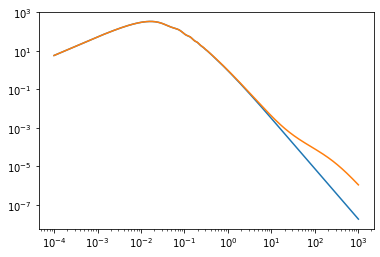

In [6]:
i = -1

k = 10**power_b1.pk_data['logk']
pkL = power_b1.pk_data['pkL']
Dp = power_b1.pk_data['Dp'][i]
z = power_b1.pk_data['z'][i]
pklin = pkL * Dp**2
pkhalo = power_b1.pk_data['pkhalo'][i,:]

print(z)

plt.figure()
plt.loglog(k, pklin)
plt.loglog(k, pkhalo)
plt.show()

[0.00836309]


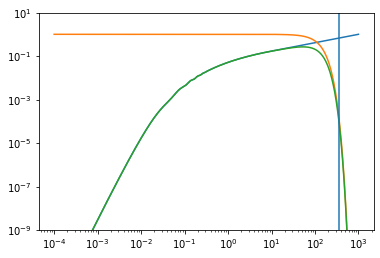

In [7]:
power_b1.halofit.set_pklin(k, pklin, z)
R_sigma = power_b1.halofit.R_sigma
power_b1.halofit.sigma(R_sigma)
print(R_sigma)

Delta = pklin*k**3/2/np.pi**2

plt.figure()
plt.ylim(1e-9, 1e1)
plt.loglog(k, Delta/Delta.max())

R = R_sigma
dump = np.exp(-k**2*R**2)
plt.loglog(k, dump/dump.max())

integrand = Delta*dump
plt.loglog(k, integrand/Delta.max())

plt.axvline(3.0/R)
plt.show()

### conclusion
takahashi halofitはz<=10までvalidationしている。z=10ではR=0.008程度なので、k~1/0.08*3程度まであれば十分。なのでtakahashi halofitを使う場合はkmax=1e3に設定すれば良い。